In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, classification_report,
    accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
)


In [ ]:
# Path to dataset
dataset_path = "/Downloads/Siar-dataset"

# List categories
categories = [c for c in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, c))]
print("Categories:", categories)


Categories: ['Normal', 'Tumor']


In [3]:
# Count images
for category in categories:
    category_path = os.path.join(dataset_path, category)
    num_images = len(os.listdir(category_path))
    print(f"{category}: {num_images} images")
    

Normal: 3800 images
Tumor: 3201 images


In [ ]:
IMG_SIZE = 150
X = []
y = []

dataset_path = "/Downloads/Siar-dataset"

categories = ['Normal', 'Tumor']

for label, category in enumerate(categories):
    folder_path = os.path.join(dataset_path, category)
    for file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, file)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img / 255.0
        X.append(img)
        y.append(label)

X = np.array(X)
y = np.array(y)


In [5]:
from skimage.feature import hog
import cv2

def extract_hog_features(img, img_size=150):
    if img.dtype != np.uint8:
        img = (img * 255).astype(np.uint8)  # Convert back to uint8 if normalized
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img
    gray = cv2.resize(gray, (img_size, img_size))
    features = hog(
        gray,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        visualize=False,
        feature_vector=True
    )
    return features


hog_features = []

for img in X:
    features = extract_hog_features(img, img_size=150)
    hog_features.append(features)

hog_features = np.array(hog_features)
print("HOG feature shape:", hog_features.shape)


HOG feature shape: (6999, 10404)


In [6]:
import cv2
import numpy as np
from skimage.feature import graycomatrix, graycoprops

def extract_glcm_features(img, img_size=150):
    if img.dtype != np.uint8:
        img = (img * 255).astype(np.uint8)  # Convert back to uint8
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, (img_size, img_size))
    gray = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    glcm = graycomatrix(gray, distances=[1], angles=[0], symmetric=True, normed=True)
    props = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
    features = [graycoprops(glcm, prop)[0, 0] for prop in props]
    return np.array(features)


glcm_features = []

for img in X:
    features = extract_glcm_features(img, img_size=150)
    glcm_features.append(features)

glcm_features = np.array(glcm_features)
print("GLCM feature shape:", glcm_features.shape)

GLCM feature shape: (6999, 6)


In [7]:
import numpy as np

combined_features = np.concatenate((hog_features, glcm_features), axis=1)
print("Combined feature shape:", combined_features.shape)


Combined feature shape: (6999, 10410)


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(combined_features, y, test_size=0.2, stratify=y, random_state=42)

print(f"Training size: {len(X_train)}")
print(f"Validation size: {len(X_val)}")


Training size: 5599
Validation size: 1400


In [9]:
# Flatten the images
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)

# Scale the pixel values
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_val_scaled = scaler.transform(X_val_flat)


In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)


In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, classification_report,
    accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
)

def evaluate_model(name, model, X_val, y_val):
    print(f"\n🔍 Evaluating {name}...")

    # Get predicted probabilities (for ROC)
    if hasattr(model, "predict_proba"):
        y_probs = model.predict_proba(X_val)[:, 1]
    else:
        y_probs = model.decision_function(X_val)

    # Convert probabilities to binary predictions
    y_pred = (y_probs > 0.5).astype(int)

    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["No Tumor", "Tumor"],
                yticklabels=["No Tumor", "Tumor"])
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Metrics
    print(classification_report(y_val, y_pred, target_names=["No Tumor", "Tumor"]))
    print(f"✅ Accuracy:  {accuracy_score(y_val, y_pred):.4f}")
    print(f"🎯 Precision: {precision_score(y_val, y_pred):.4f}")
    print(f"📈 Recall:    {recall_score(y_val, y_pred):.4f}")
    print(f"📊 F1 Score:  {f1_score(y_val, y_pred):.4f}")

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_val, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {name}")
    plt.legend()
    plt.grid(True)
    plt.show()


In [12]:
from sklearn.svm import SVC

# Train the model
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train_pca, y_train)


SVC(kernel='linear', probability=True)


🔍 Evaluating SVM...


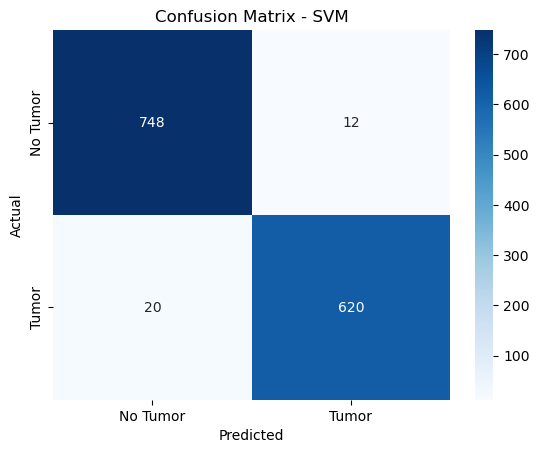

              precision    recall  f1-score   support

    No Tumor       0.97      0.98      0.98       760
       Tumor       0.98      0.97      0.97       640

    accuracy                           0.98      1400
   macro avg       0.98      0.98      0.98      1400
weighted avg       0.98      0.98      0.98      1400

✅ Accuracy:  0.9771
🎯 Precision: 0.9810
📈 Recall:    0.9688
📊 F1 Score:  0.9748


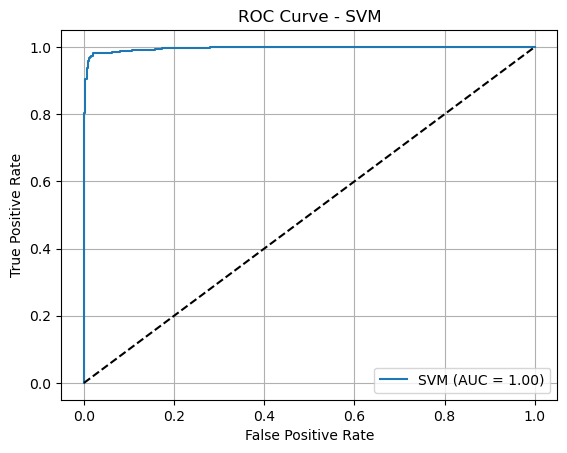

In [13]:
evaluate_model("SVM", svm_model, X_val_pca, y_val)



🔍 Evaluating Random Forest...


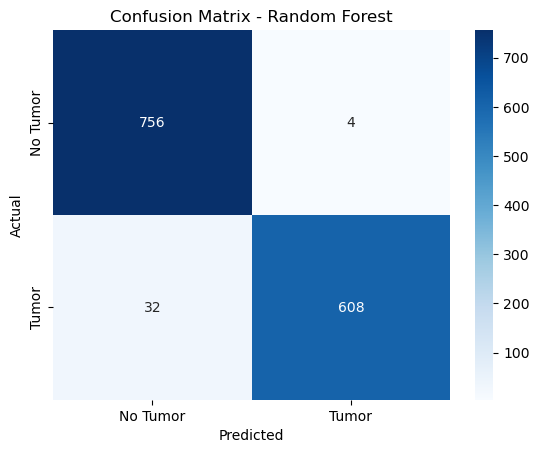

              precision    recall  f1-score   support

    No Tumor       0.96      0.99      0.98       760
       Tumor       0.99      0.95      0.97       640

    accuracy                           0.97      1400
   macro avg       0.98      0.97      0.97      1400
weighted avg       0.97      0.97      0.97      1400

✅ Accuracy:  0.9743
🎯 Precision: 0.9935
📈 Recall:    0.9500
📊 F1 Score:  0.9712


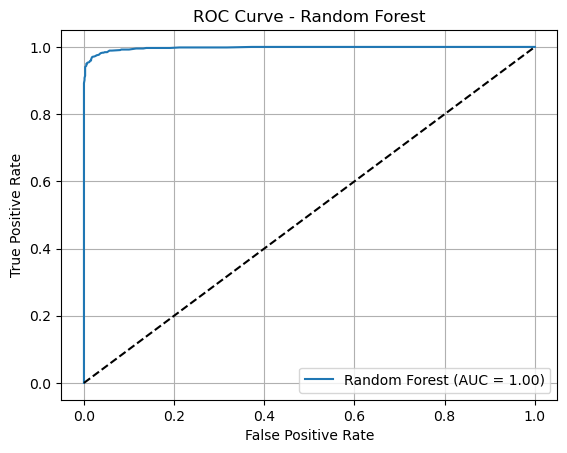

In [14]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_pca, y_train)
evaluate_model("Random Forest", rf_model, X_val_pca, y_val)



🔍 Evaluating Logistic Regression...


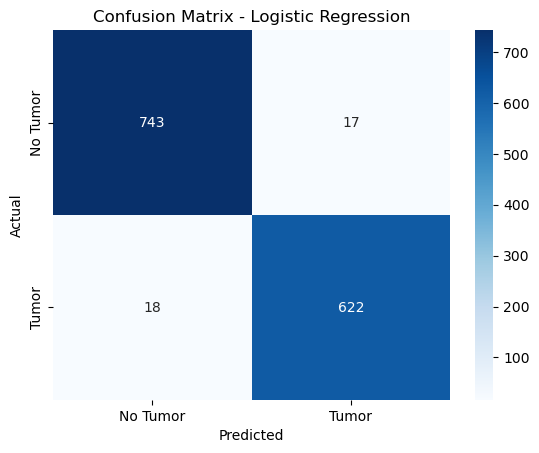

              precision    recall  f1-score   support

    No Tumor       0.98      0.98      0.98       760
       Tumor       0.97      0.97      0.97       640

    accuracy                           0.97      1400
   macro avg       0.97      0.97      0.97      1400
weighted avg       0.97      0.97      0.97      1400

✅ Accuracy:  0.9750
🎯 Precision: 0.9734
📈 Recall:    0.9719
📊 F1 Score:  0.9726


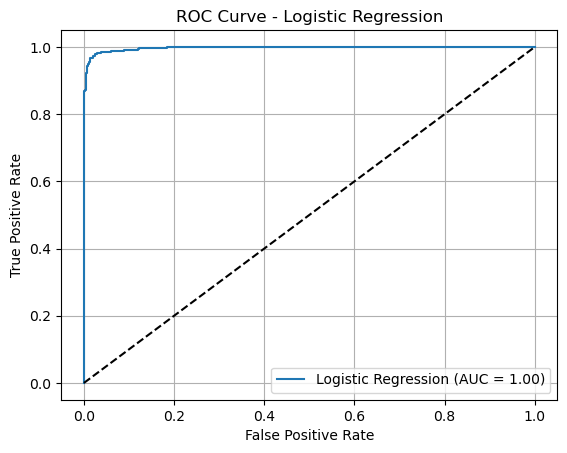

In [15]:
from sklearn.linear_model import LogisticRegression

logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(X_train_pca, y_train)
evaluate_model("Logistic Regression", logreg_model, X_val_pca, y_val)


In [16]:
import joblib
joblib.dump(svm_model, "best_model.pkl")  # or rf_model / logreg_model


['best_model.pkl']

In [60]:
def test_single_image(img_path, model, scaler, pca, img_size=(102, 102)):
    import cv2
    import numpy as np
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, img_size)
    img = img / 255.0 
    img_flat = img.reshape(1, -1)
    if img_flat.shape[1] < scaler.n_features_in_:
        padding = np.zeros((1, scaler.n_features_in_ - img_flat.shape[1]))
        img_flat = np.hstack([img_flat, padding])
        img_scaled = scaler.transform(img_flat)
        img_pca = pca.transform(img_scaled)  
    prediction = model.predict(img_pca)[0]
    print("✅ No Tumor Detected" if prediction >= 1 else "🧠 Tumor Detected")


In [ ]:
# Example usage
test_single_image("/Downloads/Siar-dataset/Tumor/Tumor ().jpg", svm_model, scaler, pca)


✅ No Tumor Detected


In [26]:
y_probs = svm_model.predict_proba(X_val_pca)[:, 1]
y_pred = (y_probs > 0.5).astype(int)

results_df = pd.DataFrame({
    "True Label": y_val,
    "Predicted": y_pred,
    "Probability": y_probs
})

results_df.to_csv("model_predictions.csv", index=False)
print("📁 Predictions saved to model_predictions.csv")


📁 Predictions saved to model_predictions.csv
